In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

pd.set_option('display.max_columns', None)

%load_ext rpy2.ipython

In [2]:
%%R
library(edgeR)

Loading required package: limma


In [3]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random

In [4]:
from matplotlib import rcParams
from matplotlib import cm, colors

#Define a nice colour map for gene expression
colors2 = plt.cm.plasma(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [5]:
plt.rcParams['figure.figsize']=(5,5) #rescale figures
sc.settings.verbosity = 3
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=300,transparent=True, fontsize=12) #color_map=mymap2)
sc.settings.figdir = '/afs/crc.nd.edu/user/e/eaboelno/sysVI_analysis/Human_scVI_single/DEG_analysis/figures'
sc.logging.print_header()

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


# Initial set up of anndata

In [6]:
adata= sc.read_h5ad('/scratch365/eaboelno/BACKUP_h5ad_IMPORTANT/scVI_mdata_MG_working.h5ad')
adata

AnnData object with n_obs × n_vars = 37619 × 29040
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'n_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'S_score', 'G2M_score', 'Cycling cells', 'Cycling_cells', 'Microglia', 'DAM', 'Macrophages', 'BAM', 'Monocytes', 'DCs

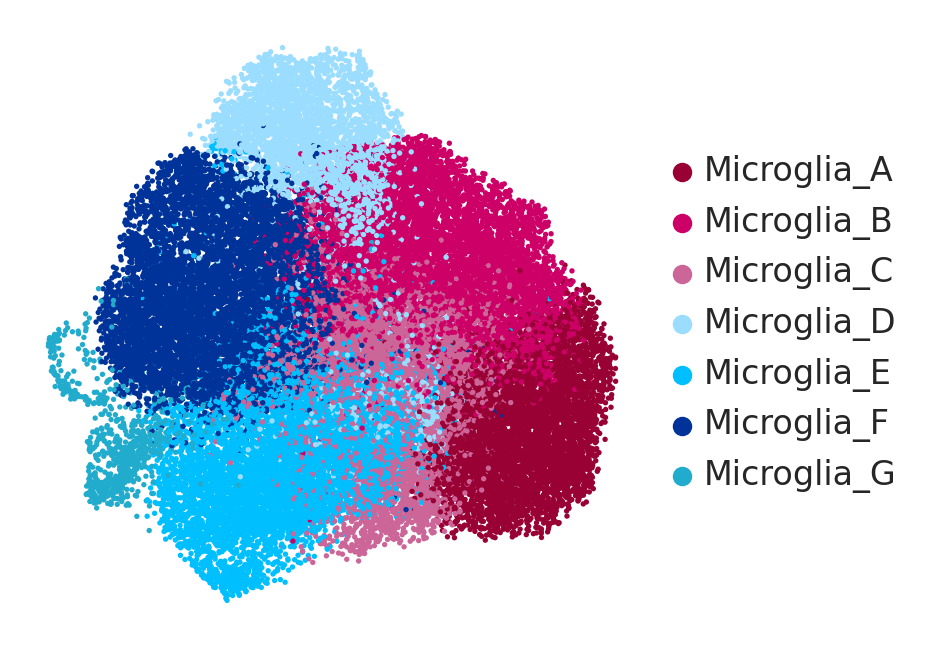

In [7]:
#Visualize the clustering and how this is reflected by different technical covariate
sc.pl.umap(adata, color=['MG_NEW_types'], legend_fontsize =float(12) , wspace=0.6, 
           cmap=mymap2,s=15,legend_fontweight= 'bold', title='', frameon= False , 
           legend_fontoutline=1)

In [8]:
cell_counts = adata.obs['MG_NEW_types'].value_counts()

# Display the counts
print(cell_counts)

MG_NEW_types
Microglia_F    7840
Microglia_B    7291
Microglia_E    7067
Microglia_A    5586
Microglia_C    5132
Microglia_D    3913
Microglia_G     790
Name: count, dtype: int64


In [9]:
# Unique values in the 'condition' column
unique_conditions = adata.obs['MG_NEW_types'].unique()
for condition in unique_conditions:
    print(condition)

Microglia_B
Microglia_A
Microglia_C
Microglia_D
Microglia_E
Microglia_G
Microglia_F


In [10]:
sample_map = {
    'Microglia_B': 'Mg_B',
    'Microglia_A': 'Mg_A',
    'Microglia_C': 'Mg_C',
    'Microglia_D': 'Mg_D',
    'Microglia_E': 'Mg_E',
    'Microglia_G': 'Mg_G',
    'Microglia_F': 'Mg_F'
}

# Update the 'treatment_meta' column based on the mapping
adata.obs['cell_type'] = adata.obs['MG_NEW_types'].map(sample_map)

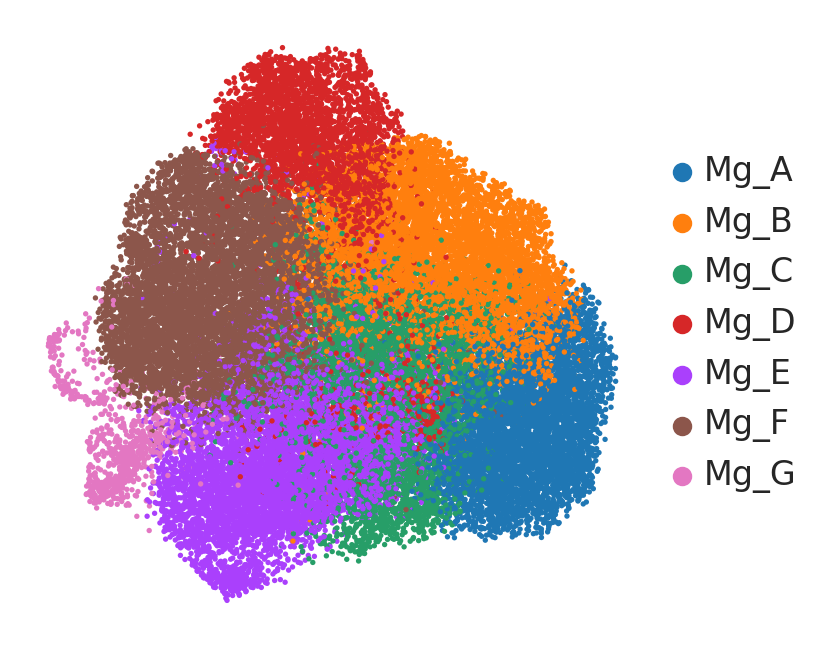

In [52]:
#Visualize the clustering and how this is reflected by different technical covariate
sc.pl.umap(adata, color=['cell_type'], legend_fontsize =float(12) , wspace=0.6, 
           cmap=mymap2,s=15,legend_fontweight= 'bold', title='', frameon= False , 
           legend_fontoutline=1)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell_type']`


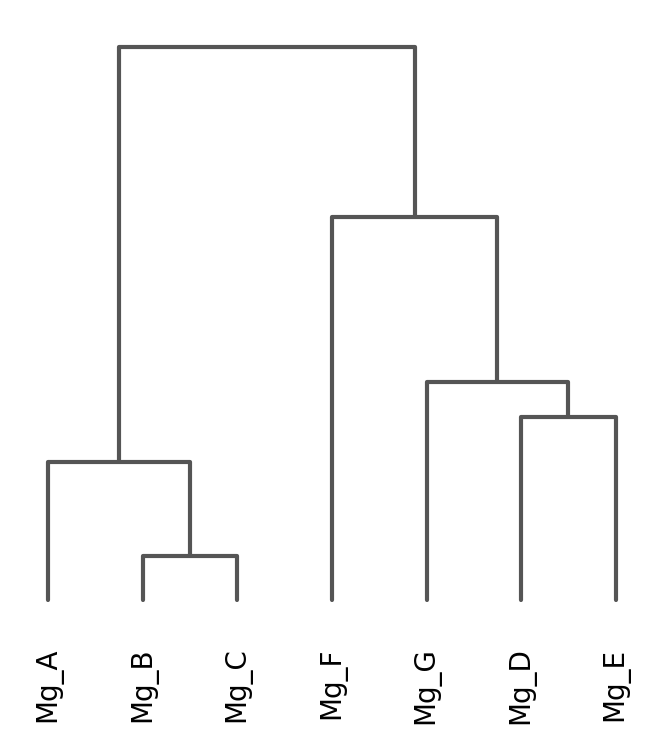

<Axes: >

In [53]:
sc.tl.dendrogram(adata, "cell_type")
sc.pl.dendrogram(adata, "cell_type")

In [54]:
#Calculate marker genes check for 100 use raw data for markers
sc.tl.rank_genes_groups(adata, groupby='cell_type', key_added='rank_genes_cell_type', 
                        method='t-test_overestim_var', use_raw=False)

ranking genes
    finished: added to `.uns['rank_genes_cell_type']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)


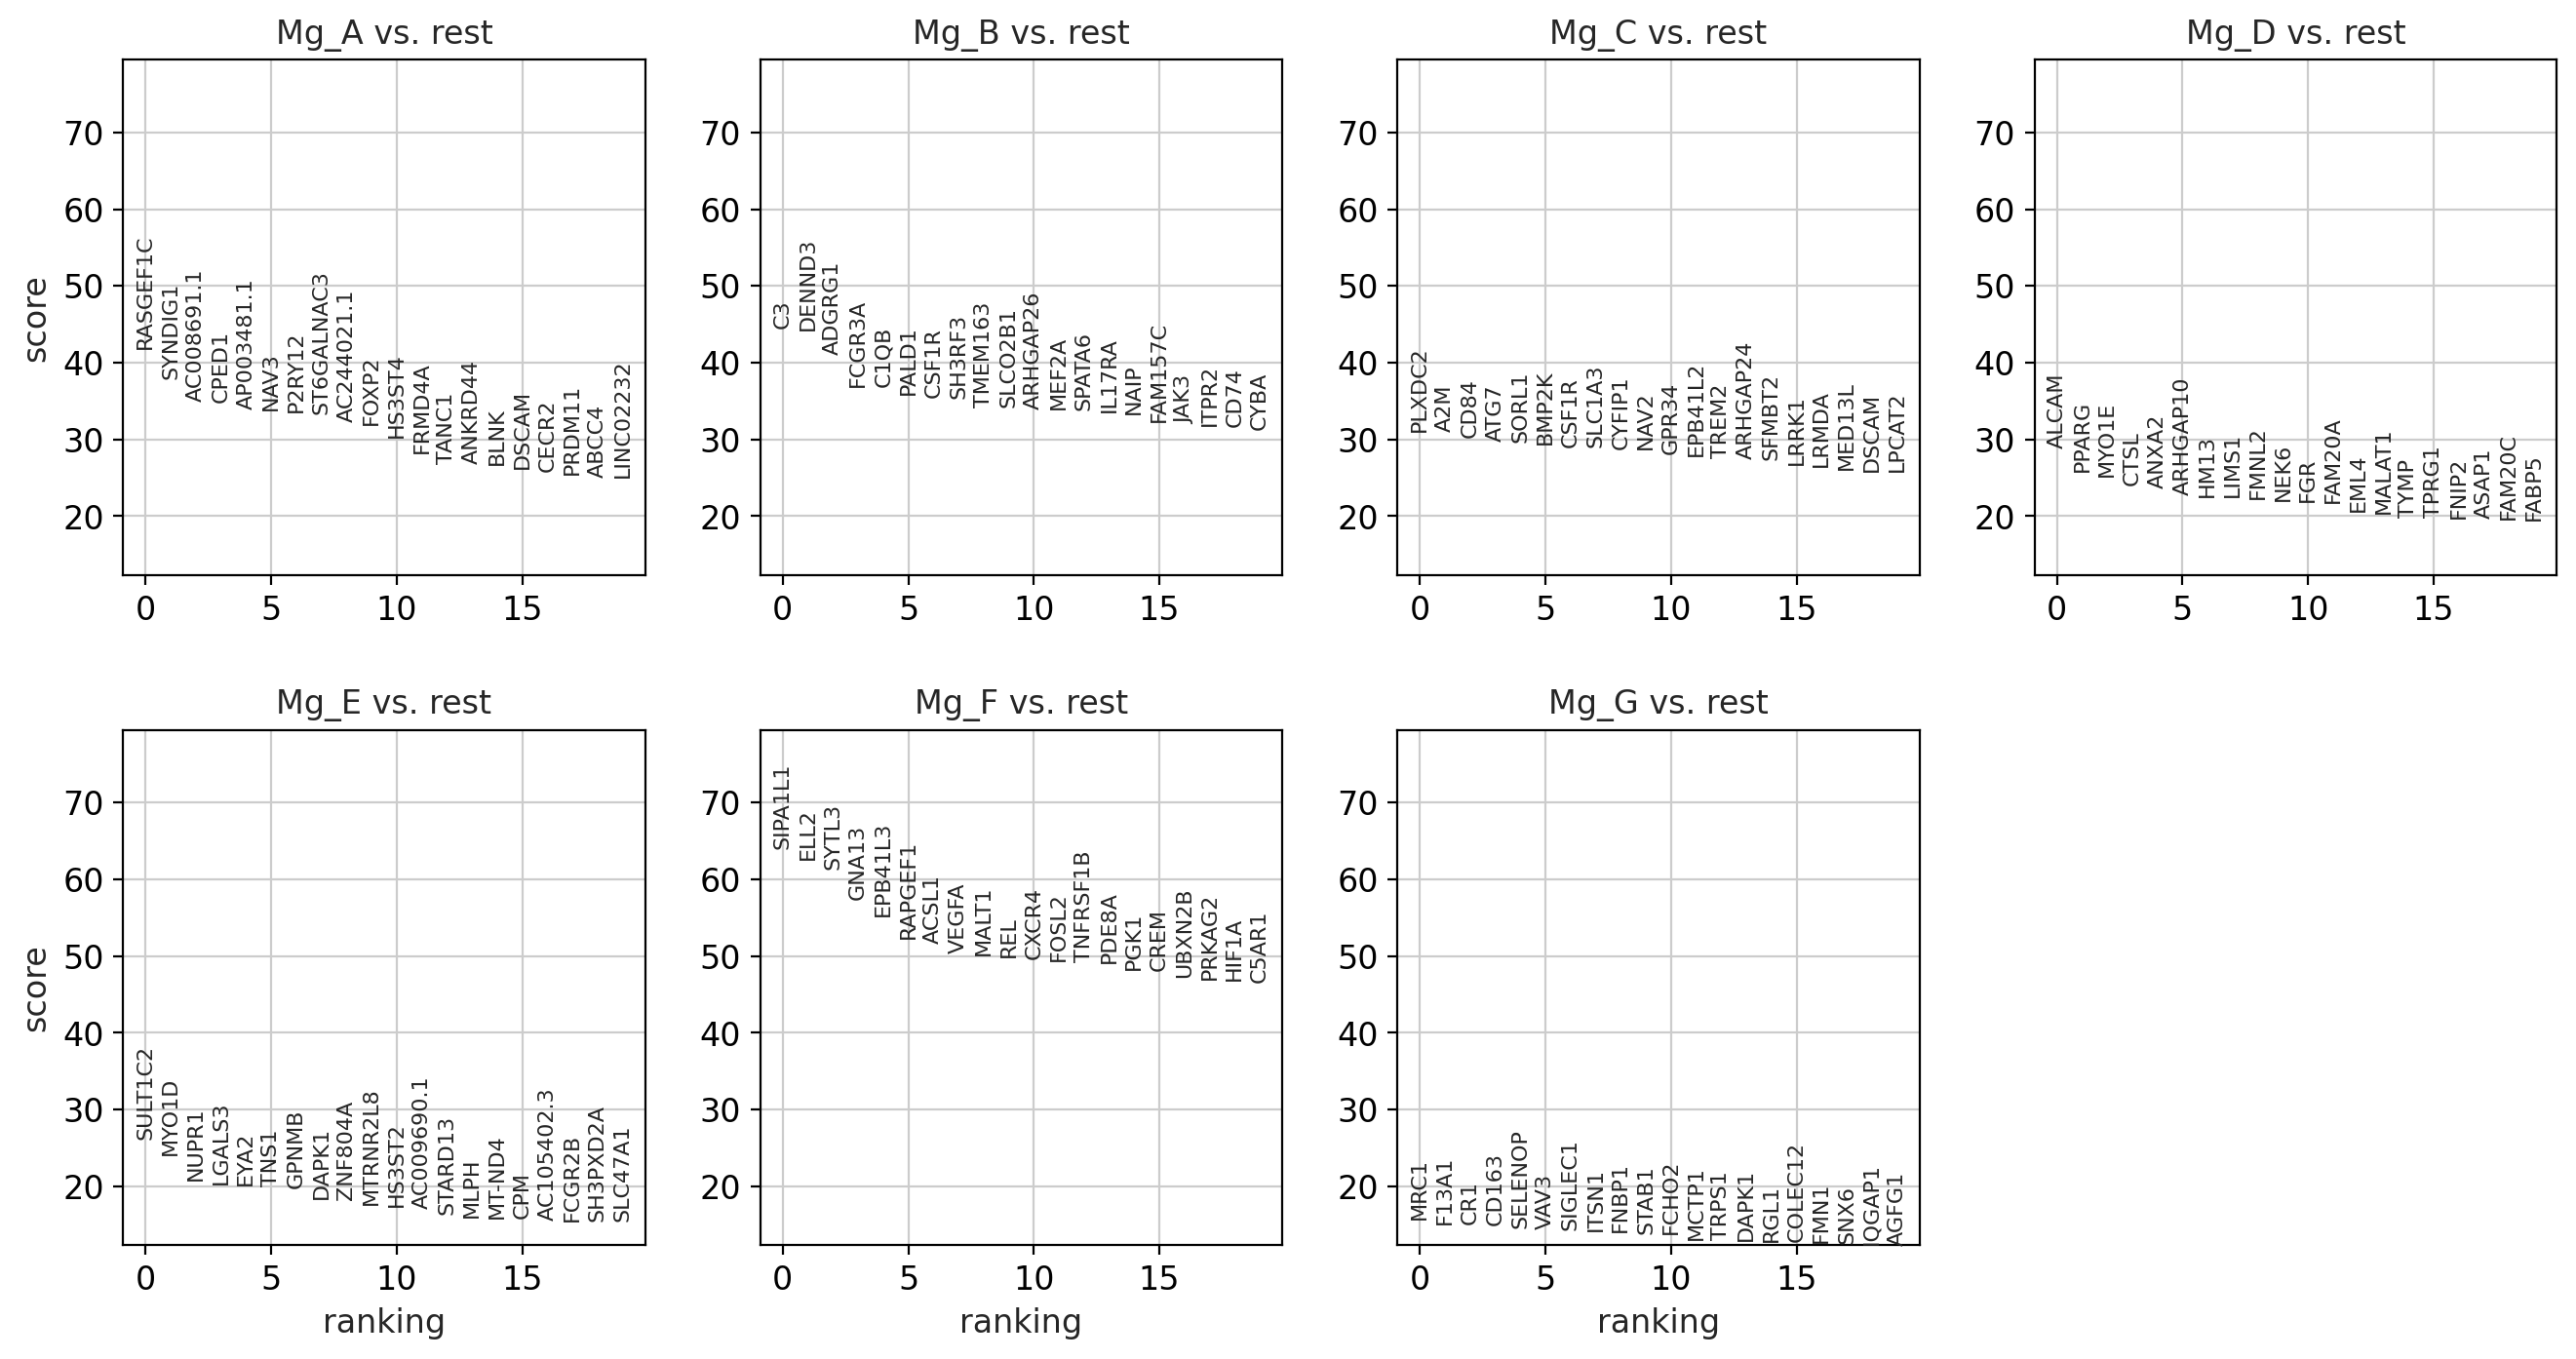

In [55]:
sc.pl.rank_genes_groups(adata, key='rank_genes_cell_type')

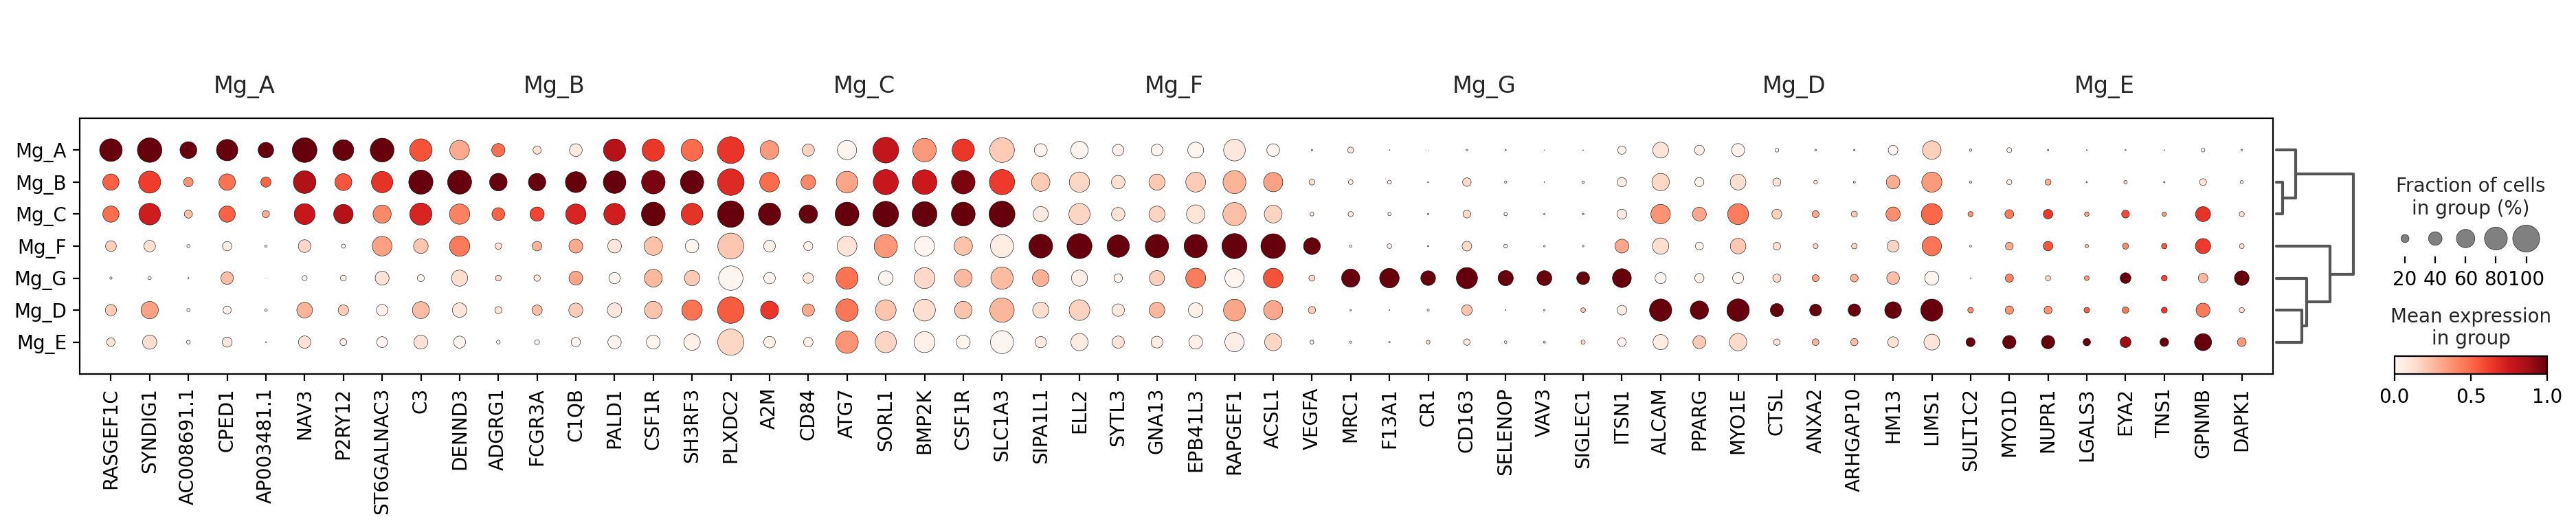

In [56]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=8, key='rank_genes_cell_type',standard_scale='var')

In [11]:
# Unique values in the 'condition' column
unique_conditions = adata.obs['cell_type'].unique()
for condition in unique_conditions:
    print(condition)

Mg_B
Mg_A
Mg_C
Mg_D
Mg_E
Mg_G
Mg_F


In [12]:
cell_counts = adata.obs['cell_type'].value_counts()

# Display the counts
print(cell_counts)

cell_type
Mg_F    7840
Mg_B    7291
Mg_E    7067
Mg_A    5586
Mg_C    5132
Mg_D    3913
Mg_G     790
Name: count, dtype: int64


In [13]:
# Extract the relevant columns
df = adata.obs[['MG_NEW_types', 'lesion_type']]

# Group by 'MG_NEW_types' and count unique 'sample_id_anon'
unique_counts = df.groupby('MG_NEW_types')['lesion_type'].nunique()
unique_counts

MG_NEW_types
Microglia_A    6
Microglia_B    6
Microglia_C    6
Microglia_D    6
Microglia_E    6
Microglia_F    6
Microglia_G    6
Name: lesion_type, dtype: int64

In [14]:
# Extract the relevant columns
df = adata.obs[['cell_type', 'sample_id_anon']]

# Group by 'MG_NEW_types' and count unique 'sample_id_anon'
unique_counts = df.groupby('cell_type')['sample_id_anon'].nunique()
unique_counts

cell_type
Mg_A    82
Mg_B    88
Mg_C    86
Mg_D    87
Mg_E    87
Mg_F    84
Mg_G    80
Name: sample_id_anon, dtype: int64

In [15]:
adata.obs[:5]

,sample_id,publication,sample_id_anon,individual_id_anon,replicate,treatment,condition,tissue,time,batch,lesion_type,sample_source,diagnosis,n_genes_by_counts,total_counts,pct_counts_mt,s_score,g2m_score,phase,cell_cycle_diff,type_fine,type_broad,cluster_zoom,exclude_pseudobulk,seq_pool,sex,age_at_death,smoker,cause_of_death,years_w_ms,pmi_minutes,age_scale,age_cat,pmi_cat,pmi_cat2,pct_counts_ribo,cell_type_eval,library_type,sample_type,organism,system,n_counts,log1p_n_genes_by_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,total_counts_ribo,log1p_total_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,S_score,G2M_score,Cycling cells,Cycling_cells,Microglia,DAM,Macrophages,BAM,Monocytes,DCs,NKT cells,T cells,B cells,Neutrophils,Neurons,OPCs,COPs,MOL,Astrocytes,Pericytes,VSMCs,VLMCs,VECV,scVI_leiden_0.5,scVI_leiden_1,cluster_annotation,cell_leiden_annotated,leiden_MG_r0.7,leiden_MG_r1,leiden_MG_r1.5,common_innate_immunity_human,IRAS1,IRAS2,MG_type_reduced,MG_type_fine,MG_leiden_annotated,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,MG_NEW_types,MG_NEW_types_lettered,cell_type
Ind98-Sample2:AAACCCATCCTGGTCT-1,Human_MS,Macnair et al. biorxiv,Ind98-Sample2,Ind98,1,MS_patient,MS,White matter,34,31,WM,Edinburgh BB,CTR,639,1732.045731,1.021766,-0.077440,0.031892,G2M,-0.109333,Micro_B,Microglia,microglia-cl02,False,Pool 6,M,34,unknown,"ischaemic heart disease, coronary artery ather...",-2147483648,5940,-1.759706,under_50,over_12H,over_12H,0.922571,microglia,10X 3p kit v3.3,sn,human,1,843.0,6.461468,7.457636,4.669481,17.697454,2.928387,15.979347,2.831998,0.000000,0.000000,0.000000,-0.014535,0.011295,-0.003595,resting,-0.032000,0.00,0.111667,-0.005,0.0,-0.004454,0.00,-0.015,0.0,0.00,-0.005143,-0.01,-0.04,-0.06,0.018072,-0.020000,-0.020000,0.00,-0.010050,2,3,Microglia,3_Microglia,0,5,0,0.048773,-0.023077,-0.030050,Homeostatic,Homeostatic,5_Homeostatic,17.697454,2.928387,1.021766,Microglia_B,B,Mg_B
Ind98-Sample2:AAAGGATCACTACCGG-1,Human_MS,Macnair et al. biorxiv,Ind98-Sample2,Ind98,1,MS_patient,MS,White matter,34,31,WM,Edinburgh BB,CTR,607,1662.147637,1.988961,-0.094974,-0.002098,G1,-0.092876,Micro_Oligo,Microglia,microglia-cl08,True,Pool 6,M,34,unknown,"ischaemic heart disease, coronary artery ather...",-2147483648,5940,-1.759706,under_50,over_12H,over_12H,0.465635,microglia,10X 3p kit v3.3,sn,human,1,820.0,6.410175,7.416467,5.000715,33.059475,3.528108,7.739542,2.167858,2.579847,1.275320,0.155212,-0.023256,-0.022166,-0.022380,resting,0.065333,-0.01,0.115000,-0.015,0.0,-0.002227,0.00,0.000,0.0,0.00,0.161714,-0.01,-0.01,-0.10,0.042169,-0.016667,-0.013333,-0.02,-0.020101,2,3,Microglia,3_Microglia,0,0,0,-0.015075,0.153846,-0.055092,Homeostatic,Homeostatic,0_Homeostatic,33.059475,3.528108,1.988961,Microglia_A,A,Mg_A
Ind98-Sample2:AAAGTCCAGGGAGGGT-1,Human_MS,Macnair et al. biorxiv,Ind98-Sample2,Ind98,1,MS_patient,MS,White matter,34,31,WM,Edinburgh BB,CTR,1475,2745.411094,0.501316,-0.053359,-0.039561,G1,-0.013798,Micro_A,Microglia,microglia-cl01,False,Pool 6,M,34,unknown,"ischaemic heart disease, coronary artery ather...",-2147483648,5940,-1.759706,under_50,over_12H,over_12H,0.560231,microglia,10X 3p kit v3.3,sn,human,1,2597.0,7.297091,7.918050,2.843516,13.763176,2.692136,15.380633,2.796100,3.742562,1.556577,0.136321,-0.001800,-0.039158,-0.042331,resting,0.936000,-0.05,-0.056667,-0.015,0.0,0.434812,0.00,-0.020,0.0,0.00,-0.177143,-0.07,-0.07,-0.50,0.012048,0.086190,-0.046667,-0.01,-0.050251,2,3,Microglia,3_Microglia,0,0,17,-0.040201,-0.025641,-0.042478,Homeostatic,Homeostatic,0_Homeostatic,13.763176,2.692136,0.501316,Microglia_A,A,Mg_A
Ind98-Sample2:AAAGTGATCGGCTTCT-1,Human_MS,Macnair et al. biorxiv,Ind98-Sample2,Ind98,1,MS_patient,MS,White matter,34,31,WM,Edinburgh BB,CTR,937,2130.544779,0.432295,-0.059236,-0.026803,G1,-0.032433,Micro_B,Microglia,microglia-cl02,False,Pool 6,M,34,unknown,"ischaemic heart disease, coronary artery ather...",-2147483648,5940,-1.759706,under_50,o

In [20]:
# Group and count cells per sample_id_anon and cell_type
count_table = adata.obs.groupby(['sample_id_anon', 'cell_type']).size().reset_index(name='Cell_Count')

# Pivot the table to have sample_id_anon as rows, cell_type as columns, and counts as values
pivot_table = count_table.pivot(index='sample_id_anon', columns='cell_type', values='Cell_Count').fillna(0)

# Optional: Convert float values to integers (since these are counts)
pivot_table = pivot_table.astype(int)
pivot_table

cell_type,Mg_A,Mg_B,Mg_C,Mg_D,Mg_E,Mg_F,Mg_G
sample_id_anon,,,,,,,
Ind86-Sample2,4,1,0,1,0,0,0
Ind98-Sample2,115,20,12,1,2,1,1
Ind101-Sample1,1,35,2,0,2,6,1
Ind101-Sample2,1,94,6,2,6,5,4
Ind101-Sample3,0,28,2,1,2,4,2
...,...,...,...,...,...,...,...
Ind143-Sample1,64,3,37,36,17,0,1
Ind144-Sample1,15,85,102,2,43,381,2
Ind145-Sample1,439,232,62,8,15,8,14


# Set up columns for PB

In [16]:
# Concatenate 'individual_lesion_condition' and 'replicate' to create 'sample'
adata.obs['sample_lesion'] = adata.obs['sample_id_anon'].astype(str) + '_' + adata.obs['lesion_type'].astype(str)

In [17]:
# Unique values in the 'condition' column
unique_conditions = adata.obs['sample_lesion'].unique()
for condition in unique_conditions:
    print(condition)

Ind98-Sample2_WM
Ind101-Sample1_CIL
Ind101-Sample2_CIL
Ind101-Sample3_RL
Ind101-Sample4_NAWM
Ind102-Sample1_AL
Ind103-Sample1_AL
Ind102-Sample2_CAL
Ind86-Sample2_WM
Ind104-Sample1_RL
Ind105-Sample1_NAWM
Ind106-Sample1_AL
Ind106-Sample2_NAWM
Ind107-Sample1_WM
Ind108-Sample1_CIL
Ind108-Sample2_CIL
Ind108-Sample3_RL
Ind108-Sample4_RL
Ind108-Sample5_NAWM
Ind109-Sample1_AL
Ind110-Sample1_CAL
Ind111-Sample1_NAWM
Ind112-Sample1_AL
Ind113-Sample1_AL
Ind114-Sample1_AL
Ind115-Sample1_AL
Ind116-Sample1_CAL
Ind117-Sample1_WM
Ind108-Sample6_CIL
Ind118-Sample1_AL
Ind118-Sample2_AL
Ind119-Sample1_CAL
Ind120-Sample1_CAL
Ind118-Sample3_NAWM
Ind120-Sample2_NAWM
Ind121-Sample1_WM
Ind122-Sample1_AL
Ind114-Sample2_AL
Ind123-Sample1_CAL
Ind124-Sample1_CAL
Ind125-Sample1_NAWM
Ind122-Sample2_NAWM
Ind126-Sample1_WM
Ind127-Sample1_AL
Ind116-Sample2_CAL
Ind127-Sample2_CAL
Ind128-Sample1_CIL
Ind102-Sample3_CIL
Ind116-Sample3_NAWM
Ind112-Sample2_NAWM
Ind130-Sample1_AL
Ind130-Sample2_AL
Ind130-Sample3_CAL
Ind114-Sa

In [27]:
# List of samples
samples = [
    'Ind98-Sample2_WM', 'Ind101-Sample1_CIL', 'Ind101-Sample2_CIL', 'Ind101-Sample3_RL',
    'Ind101-Sample4_NAWM', 'Ind102-Sample1_AL', 'Ind103-Sample1_AL', 'Ind102-Sample2_CAL',
    'Ind86-Sample2_WM', 'Ind104-Sample1_RL', 'Ind105-Sample1_NAWM', 'Ind106-Sample1_AL',
    'Ind106-Sample2_NAWM', 'Ind107-Sample1_WM', 'Ind108-Sample1_CIL', 'Ind108-Sample2_CIL',
    'Ind108-Sample3_RL', 'Ind108-Sample4_RL', 'Ind108-Sample5_NAWM', 'Ind109-Sample1_AL',
    'Ind110-Sample1_CAL', 'Ind111-Sample1_NAWM', 'Ind112-Sample1_AL', 'Ind113-Sample1_AL',
    'Ind114-Sample1_AL', 'Ind115-Sample1_AL', 'Ind116-Sample1_CAL', 'Ind117-Sample1_WM',
    'Ind108-Sample6_CIL', 'Ind118-Sample1_AL', 'Ind118-Sample2_AL', 'Ind119-Sample1_CAL',
    'Ind120-Sample1_CAL', 'Ind118-Sample3_NAWM', 'Ind120-Sample2_NAWM', 'Ind121-Sample1_WM',
    'Ind122-Sample1_AL', 'Ind114-Sample2_AL', 'Ind123-Sample1_CAL', 'Ind124-Sample1_CAL',
    'Ind125-Sample1_NAWM', 'Ind122-Sample2_NAWM', 'Ind126-Sample1_WM', 'Ind127-Sample1_AL',
    'Ind116-Sample2_CAL', 'Ind127-Sample2_CAL', 'Ind128-Sample1_CIL', 'Ind102-Sample3_CIL',
    'Ind116-Sample3_NAWM', 'Ind112-Sample2_NAWM', 'Ind130-Sample1_AL', 'Ind130-Sample2_AL',
    'Ind130-Sample3_CAL', 'Ind114-Sample3_CAL', 'Ind123-Sample2_CIL', 'Ind123-Sample3_CIL',
    'Ind130-Sample4_NAWM', 'Ind131-Sample1_WM', 'Ind132-Sample1_AL', 'Ind127-Sample3_AL',
    'Ind127-Sample4_AL', 'Ind130-Sample5_CAL', 'Ind104-Sample2_CIL', 'Ind104-Sample3_NAWM',
    'Ind133-Sample1_WM', 'Ind134-Sample1_CIL', 'Ind134-Sample2_CIL', 'Ind134-Sample3_RL',
    'Ind134-Sample4_NAWM', 'Ind113-Sample2_AL', 'Ind118-Sample4_CAL', 'Ind113-Sample3_NAWM',
    'Ind135-Sample1_WM', 'Ind136-Sample1_CAL', 'Ind137-Sample1_CAL', 'Ind109-Sample2_CIL',
    'Ind109-Sample3_NAWM', 'Ind132-Sample2_NAWM', 'Ind139-Sample1_WM', 'Ind140-Sample1_WM',
    'Ind141-Sample1_RL', 'Ind142-Sample1_RL', 'Ind141-Sample2_RL', 'Ind127-Sample5_CAL',
    'Ind143-Sample1_AL', 'Ind144-Sample1_WM', 'Ind145-Sample1_WM', 'Ind142-Sample2_RL',
    'Ind146-Sample1_RL', 'Ind147-Sample1_RL', 'Ind115-Sample2_AL', 'Ind102-Sample4_CAL'
]

# Initialize counters
wm_counter, nawm_counter, al_counter, cal_counter, cil_counter, rl_counter = 1, 1, 1, 1, 1, 1

# Initialize dictionary
sample_dict = {}

# Iterate through the list of samples and map based on conditions
for sample in samples:
    if "NAWM" in sample:  # Check for NAWM first
        sample_dict[sample] = f"NAWM_{nawm_counter}"
        nawm_counter += 1
    elif "WM" in sample:  # Check for WM
        sample_dict[sample] = f"WM_{wm_counter}"
        wm_counter += 1
    elif "AL" in sample and "CAL" not in sample:  # Check specifically for AL (but not CAL)
        sample_dict[sample] = f"AL_{al_counter}"
        print(f"{sample} = AL_{al_counter}")
        al_counter += 1
    elif "CAL" in sample:  # Check for CAL
        sample_dict[sample] = f"CAL_{cal_counter}"
        print(f"{sample} = CAL_{cal_counter}")
        cal_counter += 1
    elif "CIL" in sample:  # Check for CIL
        sample_dict[sample] = f"CIL_{cil_counter}"
        print(f"{sample} = CIL_{cil_counter}")
        cil_counter += 1
    elif "RL" in sample:  # Check for RL
        sample_dict[sample] = f"RL_{rl_counter}"
        print(f"{sample} = RL_{rl_counter}")
        rl_counter += 1

# Print the resulting dictionary
from pprint import pprint
pprint(sample_dict)

Ind101-Sample1_CIL = CIL_1
Ind101-Sample2_CIL = CIL_2
Ind101-Sample3_RL = RL_1
Ind102-Sample1_AL = AL_1
Ind103-Sample1_AL = AL_2
Ind102-Sample2_CAL = CAL_1
Ind104-Sample1_RL = RL_2
Ind106-Sample1_AL = AL_3
Ind108-Sample1_CIL = CIL_3
Ind108-Sample2_CIL = CIL_4
Ind108-Sample3_RL = RL_3
Ind108-Sample4_RL = RL_4
Ind109-Sample1_AL = AL_4
Ind110-Sample1_CAL = CAL_2
Ind112-Sample1_AL = AL_5
Ind113-Sample1_AL = AL_6
Ind114-Sample1_AL = AL_7
Ind115-Sample1_AL = AL_8
Ind116-Sample1_CAL = CAL_3
Ind108-Sample6_CIL = CIL_5
Ind118-Sample1_AL = AL_9
Ind118-Sample2_AL = AL_10
Ind119-Sample1_CAL = CAL_4
Ind120-Sample1_CAL = CAL_5
Ind122-Sample1_AL = AL_11
Ind114-Sample2_AL = AL_12
Ind123-Sample1_CAL = CAL_6
Ind124-Sample1_CAL = CAL_7
Ind127-Sample1_AL = AL_13
Ind116-Sample2_CAL = CAL_8
Ind127-Sample2_CAL = CAL_9
Ind128-Sample1_CIL = CIL_6
Ind102-Sample3_CIL = CIL_7
Ind130-Sample1_AL = AL_14
Ind130-Sample2_AL = AL_15
Ind130-Sample3_CAL = CAL_10
Ind114-Sample3_CAL = CAL_11
Ind123-Sample2_CIL = CIL_8
Ind1

In [28]:
sample_dict = {'Ind101-Sample1_CIL': 'CIL_1',
 'Ind101-Sample2_CIL': 'CIL_2',
 'Ind101-Sample3_RL': 'RL_1',
 'Ind101-Sample4_NAWM': 'NAWM_1',
 'Ind102-Sample1_AL': 'AL_1',
 'Ind102-Sample2_CAL': 'CAL_1',
 'Ind102-Sample3_CIL': 'CIL_7',
 'Ind102-Sample4_CAL': 'CAL_17',
 'Ind103-Sample1_AL': 'AL_2',
 'Ind104-Sample1_RL': 'RL_2',
 'Ind104-Sample2_CIL': 'CIL_10',
 'Ind104-Sample3_NAWM': 'NAWM_13',
 'Ind105-Sample1_NAWM': 'NAWM_2',
 'Ind106-Sample1_AL': 'AL_3',
 'Ind106-Sample2_NAWM': 'NAWM_3',
 'Ind107-Sample1_WM': 'WM_3',
 'Ind108-Sample1_CIL': 'CIL_3',
 'Ind108-Sample2_CIL': 'CIL_4',
 'Ind108-Sample3_RL': 'RL_3',
 'Ind108-Sample4_RL': 'RL_4',
 'Ind108-Sample5_NAWM': 'NAWM_4',
 'Ind108-Sample6_CIL': 'CIL_5',
 'Ind109-Sample1_AL': 'AL_4',
 'Ind109-Sample2_CIL': 'CIL_13',
 'Ind109-Sample3_NAWM': 'NAWM_16',
 'Ind110-Sample1_CAL': 'CAL_2',
 'Ind111-Sample1_NAWM': 'NAWM_5',
 'Ind112-Sample1_AL': 'AL_5',
 'Ind112-Sample2_NAWM': 'NAWM_11',
 'Ind113-Sample1_AL': 'AL_6',
 'Ind113-Sample2_AL': 'AL_19',
 'Ind113-Sample3_NAWM': 'NAWM_15',
 'Ind114-Sample1_AL': 'AL_7',
 'Ind114-Sample2_AL': 'AL_12',
 'Ind114-Sample3_CAL': 'CAL_11',
 'Ind115-Sample1_AL': 'AL_8',
 'Ind115-Sample2_AL': 'AL_21',
 'Ind116-Sample1_CAL': 'CAL_3',
 'Ind116-Sample2_CAL': 'CAL_8',
 'Ind116-Sample3_NAWM': 'NAWM_10',
 'Ind117-Sample1_WM': 'WM_4',
 'Ind118-Sample1_AL': 'AL_9',
 'Ind118-Sample2_AL': 'AL_10',
 'Ind118-Sample3_NAWM': 'NAWM_6',
 'Ind118-Sample4_CAL': 'CAL_13',
 'Ind119-Sample1_CAL': 'CAL_4',
 'Ind120-Sample1_CAL': 'CAL_5',
 'Ind120-Sample2_NAWM': 'NAWM_7',
 'Ind121-Sample1_WM': 'WM_5',
 'Ind122-Sample1_AL': 'AL_11',
 'Ind122-Sample2_NAWM': 'NAWM_9',
 'Ind123-Sample1_CAL': 'CAL_6',
 'Ind123-Sample2_CIL': 'CIL_8',
 'Ind123-Sample3_CIL': 'CIL_9',
 'Ind124-Sample1_CAL': 'CAL_7',
 'Ind125-Sample1_NAWM': 'NAWM_8',
 'Ind126-Sample1_WM': 'WM_6',
 'Ind127-Sample1_AL': 'AL_13',
 'Ind127-Sample2_CAL': 'CAL_9',
 'Ind127-Sample3_AL': 'AL_17',
 'Ind127-Sample4_AL': 'AL_18',
 'Ind127-Sample5_CAL': 'CAL_16',
 'Ind128-Sample1_CIL': 'CIL_6',
 'Ind130-Sample1_AL': 'AL_14',
 'Ind130-Sample2_AL': 'AL_15',
 'Ind130-Sample3_CAL': 'CAL_10',
 'Ind130-Sample4_NAWM': 'NAWM_12',
 'Ind130-Sample5_CAL': 'CAL_12',
 'Ind131-Sample1_WM': 'WM_7',
 'Ind132-Sample1_AL': 'AL_16',
 'Ind132-Sample2_NAWM': 'NAWM_17',
 'Ind133-Sample1_WM': 'WM_8',
 'Ind134-Sample1_CIL': 'CIL_11',
 'Ind134-Sample2_CIL': 'CIL_12',
 'Ind134-Sample3_RL': 'RL_5',
 'Ind134-Sample4_NAWM': 'NAWM_14',
 'Ind135-Sample1_WM': 'WM_9',
 'Ind136-Sample1_CAL': 'CAL_14',
 'Ind137-Sample1_CAL': 'CAL_15',
 'Ind139-Sample1_WM': 'WM_10',
 'Ind140-Sample1_WM': 'WM_11',
 'Ind141-Sample1_RL': 'RL_6',
 'Ind141-Sample2_RL': 'RL_8',
 'Ind142-Sample1_RL': 'RL_7',
 'Ind142-Sample2_RL': 'RL_9',
 'Ind143-Sample1_AL': 'AL_20',
 'Ind144-Sample1_WM': 'WM_12',
 'Ind145-Sample1_WM': 'WM_13',
 'Ind146-Sample1_RL': 'RL_10',
 'Ind147-Sample1_RL': 'RL_11',
 'Ind86-Sample2_WM': 'WM_2',
 'Ind98-Sample2_WM': 'WM_1'}


# Update the 'treatment_meta' column based on the mapping
adata.obs['sample_rep'] = adata.obs['sample_lesion'].map(sample_dict)

In [29]:
# List of values
values = [
    'WM_1', 'CIL_1', 'CIL_2', 'RL_1', 'NAWM_1', 'AL_1', 'AL_2', 'CAL_1', 'WM_2', 'RL_2', 'NAWM_2', 'AL_3', 
    'NAWM_3', 'WM_3', 'CIL_3', 'CIL_4', 'RL_3', 'RL_4', 'NAWM_4', 'AL_4', 'CAL_2', 'NAWM_5', 'AL_5', 'AL_6', 
    'AL_7', 'AL_8', 'CAL_3', 'WM_4', 'CIL_5', 'AL_9', 'AL_10', 'CAL_4', 'CAL_5', 'NAWM_6', 'NAWM_7', 'WM_5', 
    'AL_11', 'AL_12', 'CAL_6', 'CAL_7', 'NAWM_8', 'NAWM_9', 'WM_6', 'AL_13', 'CAL_8', 'CAL_9', 'CIL_6', 
    'CIL_7',
    'NAWM_10',
    'NAWM_11',
    'AL_14',
    'AL_15',
    'CAL_10',
    'CAL_11',
    'CIL_8',
    'CIL_9',
    'NAWM_12',
    'WM_7',
    'AL_16',
    'AL_17',
    'AL_18',
    'CAL_12',
    'CIL_10',
    'NAWM_13',
    'WM_8',
    'CIL_11',
    'CIL_12',
    'RL_5',
    'NAWM_14',
    'AL_19',
    'CAL_13',
    'NAWM_15',
    'WM_9',
    'CAL_14',
    'CAL_15',
    'CIL_13',
    'NAWM_16',
    'NAWM_17',
    'WM_10',
    'WM_11',
    'RL_6',
    'RL_7',
    'RL_8',
    'CAL_16',
    'AL_20',
    'WM_12',
    'WM_13',
    'RL_9',
    'RL_10',
    'RL_11',
    'AL_21',
    'CAL_17'
]

# Extract replicate numbers into a dictionary
replicate_dict = {value: int(value.split('_')[-1]) for value in values}

# Display the dictionary
from pprint import pprint
pprint(replicate_dict)

{'AL_1': 1,
 'AL_10': 10,
 'AL_11': 11,
 'AL_12': 12,
 'AL_13': 13,
 'AL_14': 14,
 'AL_15': 15,
 'AL_16': 16,
 'AL_17': 17,
 'AL_18': 18,
 'AL_19': 19,
 'AL_2': 2,
 'AL_20': 20,
 'AL_21': 21,
 'AL_3': 3,
 'AL_4': 4,
 'AL_5': 5,
 'AL_6': 6,
 'AL_7': 7,
 'AL_8': 8,
 'AL_9': 9,
 'CAL_1': 1,
 'CAL_10': 10,
 'CAL_11': 11,
 'CAL_12': 12,
 'CAL_13': 13,
 'CAL_14': 14,
 'CAL_15': 15,
 'CAL_16': 16,
 'CAL_17': 17,
 'CAL_2': 2,
 'CAL_3': 3,
 'CAL_4': 4,
 'CAL_5': 5,
 'CAL_6': 6,
 'CAL_7': 7,
 'CAL_8': 8,
 'CAL_9': 9,
 'CIL_1': 1,
 'CIL_10': 10,
 'CIL_11': 11,
 'CIL_12': 12,
 'CIL_13': 13,
 'CIL_2': 2,
 'CIL_3': 3,
 'CIL_4': 4,
 'CIL_5': 5,
 'CIL_6': 6,
 'CIL_7': 7,
 'CIL_8': 8,
 'CIL_9': 9,
 'NAWM_1': 1,
 'NAWM_10': 10,
 'NAWM_11': 11,
 'NAWM_12': 12,
 'NAWM_13': 13,
 'NAWM_14': 14,
 'NAWM_15': 15,
 'NAWM_16': 16,
 'NAWM_17': 17,
 'NAWM_2': 2,
 'NAWM_3': 3,
 'NAWM_4': 4,
 'NAWM_5': 5,
 'NAWM_6': 6,
 'NAWM_7': 7,
 'NAWM_8': 8,
 'NAWM_9': 9,
 'RL_1': 1,
 'RL_10': 10,
 'RL_11': 11,
 'RL_2': 2,
 'RL

In [30]:
# Update the 'treatment_meta' column based on the mapping
adata.obs['replicate_cat'] = adata.obs['sample_rep'].map(replicate_dict)

In [31]:
# Extract the prefix before the `_` into a dictionary
prefix_dict = {value: value.split('_')[0] for value in values}

# Display the dictionary
from pprint import pprint
pprint(prefix_dict)

{'AL_1': 'AL',
 'AL_10': 'AL',
 'AL_11': 'AL',
 'AL_12': 'AL',
 'AL_13': 'AL',
 'AL_14': 'AL',
 'AL_15': 'AL',
 'AL_16': 'AL',
 'AL_17': 'AL',
 'AL_18': 'AL',
 'AL_19': 'AL',
 'AL_2': 'AL',
 'AL_20': 'AL',
 'AL_21': 'AL',
 'AL_3': 'AL',
 'AL_4': 'AL',
 'AL_5': 'AL',
 'AL_6': 'AL',
 'AL_7': 'AL',
 'AL_8': 'AL',
 'AL_9': 'AL',
 'CAL_1': 'CAL',
 'CAL_10': 'CAL',
 'CAL_11': 'CAL',
 'CAL_12': 'CAL',
 'CAL_13': 'CAL',
 'CAL_14': 'CAL',
 'CAL_15': 'CAL',
 'CAL_16': 'CAL',
 'CAL_17': 'CAL',
 'CAL_2': 'CAL',
 'CAL_3': 'CAL',
 'CAL_4': 'CAL',
 'CAL_5': 'CAL',
 'CAL_6': 'CAL',
 'CAL_7': 'CAL',
 'CAL_8': 'CAL',
 'CAL_9': 'CAL',
 'CIL_1': 'CIL',
 'CIL_10': 'CIL',
 'CIL_11': 'CIL',
 'CIL_12': 'CIL',
 'CIL_13': 'CIL',
 'CIL_2': 'CIL',
 'CIL_3': 'CIL',
 'CIL_4': 'CIL',
 'CIL_5': 'CIL',
 'CIL_6': 'CIL',
 'CIL_7': 'CIL',
 'CIL_8': 'CIL',
 'CIL_9': 'CIL',
 'NAWM_1': 'NAWM',
 'NAWM_10': 'NAWM',
 'NAWM_11': 'NAWM',
 'NAWM_12': 'NAWM',
 'NAWM_13': 'NAWM',
 'NAWM_14': 'NAWM',
 'NAWM_15': 'NAWM',
 'NAWM_16': 

In [32]:
# Update the 'treatment_meta' column based on the mapping
adata.obs['stim'] = adata.obs['sample_rep'].map(prefix_dict)

In [33]:
# Convert 'replicate_new' to a categorical type
adata.obs['replicate_cat'] = adata.obs['replicate_cat'].astype('category')

In [34]:
print(len(adata[adata.obs["stim"] == "WM"].obs["replicate_cat"].cat.categories))
print(len(adata[adata.obs["stim"] == "NAWM"].obs["replicate_cat"].cat.categories))
print(len(adata[adata.obs["stim"] == "AL"].obs["replicate_cat"].cat.categories))
print(len(adata[adata.obs["stim"] == "CAL"].obs["replicate_cat"].cat.categories))
print(len(adata[adata.obs["stim"] == "CIL"].obs["replicate_cat"].cat.categories))
print(len(adata[adata.obs["stim"] == "RL"].obs["replicate_cat"].cat.categories))

13
17
21
17
13
11


# Run pseudobulk aggregation on all cell types, LPC

In [35]:
# Unique values in the 'condition' column
unique_conditions = adata.obs['cell_type'].unique()
for condition in unique_conditions:
    print(condition)

Mg_B
Mg_A
Mg_C
Mg_D
Mg_E
Mg_G
Mg_F


In [36]:
# Update the 'treatment_meta' column based on the mapping
adata.obs['sample'] = adata.obs['sample_id_anon']

In [37]:
# Unique values in the 'cell_type' column
unique_conditions = adata.obs['sample_id_anon'].unique()

# Find the number of unique conditions
num_unique_conditions = len(unique_conditions)

print(f"Number of unique conditions: {num_unique_conditions}")

Number of unique conditions: 92


In [38]:
NUM_OF_CELL_PER_DONOR = 15

def aggregate_and_filter(
    adata, #input anndata
    cell_identity, #subset for processing by cell type
    donor_key="sample", #'6_stim' sets the donor key as reps for each condition
    condition_key="stim", #ctrl or stim
    cell_identity_key="cell_type", #cell type identifier
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

In [39]:
adata

AnnData object with n_obs × n_vars = 37619 × 29040
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'n_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'S_score', 'G2M_score', 'Cycling cells', 'Cycling_cells', 'Microglia', 'DAM', 'Macrophages', 'BAM', 'Monocytes', 'DCs

In [40]:
obs_to_keep = ["sample", "sample_lesion", "diagnosis", "sample_source", "cell_type", "sample_rep", "replicate_cat", "stim",
              "sex", "seq_pool", "age_scale", "age_cat", "pmi_cat", "pmi_cat2"]

In [41]:
adata.X = adata.layers["counts"].copy()

In [42]:
adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")

In [43]:
# process first cell type separately...
cell_type = adata.obs["cell_type"].cat.categories[0]
print(
    f'Processing {cell_type} (1 out of {len(adata.obs["cell_type"].cat.categories)})...'
)
adata_pb = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
for i, cell_type in enumerate(adata.obs["cell_type"].cat.categories[1:]):
    print(
        f'Processing {cell_type} ({i+2} out of {len(adata.obs["cell_type"].cat.categories)})...'
    )
    adata_cell_type = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
    adata_pb = adata_pb.concatenate(adata_cell_type)

Processing Mg_A (1 out of 7)...
Dropping the following samples:
['Ind86-Sample2', 'Ind101-Sample1', 'Ind101-Sample2', 'Ind101-Sample4', 'Ind102-Sample2', 'Ind102-Sample3', 'Ind104-Sample2', 'Ind104-Sample3', 'Ind105-Sample1', 'Ind108-Sample2', 'Ind108-Sample4', 'Ind109-Sample1', 'Ind110-Sample1', 'Ind111-Sample1', 'Ind112-Sample1', 'Ind114-Sample2', 'Ind114-Sample3', 'Ind115-Sample1', 'Ind118-Sample4', 'Ind119-Sample1', 'Ind120-Sample2', 'Ind123-Sample1', 'Ind123-Sample2', 'Ind123-Sample3', 'Ind125-Sample1', 'Ind126-Sample1', 'Ind130-Sample3', 'Ind130-Sample5', 'Ind134-Sample1', 'Ind134-Sample3', 'Ind136-Sample1', 'Ind137-Sample1', 'Ind141-Sample1', 'Ind144-Sample1', 'Ind146-Sample1']
	Processing donor 82 out of 82...

Processing Mg_B (2 out of 7)...
Dropping the following samples:
['Ind86-Sample2', 'Ind101-Sample4', 'Ind102-Sample1', 'Ind102-Sample2', 'Ind102-Sample4', 'Ind103-Sample1', 'Ind104-Sample2', 'Ind105-Sample1', 'Ind106-Sample1', 'Ind106-Sample2', 'Ind114-Sample1', 'Ind114-S

In [44]:
adata_pb

AnnData object with n_obs × n_vars = 292 × 29040
    obs: 'sample', 'sample_lesion', 'diagnosis', 'sample_source', 'cell_type', 'sample_rep', 'replicate_cat', 'stim', 'sex', 'seq_pool', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'batch'

In [45]:
adata_pb.layers['counts'] = adata_pb.X.copy()
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


In [46]:
# Ensure counts are integers (if not already)
adata_pb.layers["counts"] = adata_pb.layers["counts"].astype(int)

# Calculate library size
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)

# Calculate log library size
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"].astype(float))

#obs_to_keep = ["sample", "sample_lesion", "cell_type", "sample_rep", "replicate_cat", "stim"]
adata_pb.obs["sample"] = adata_pb.obs["sample"].astype("category")
adata_pb.obs["sample_lesion"] = adata_pb.obs["sample_lesion"].astype("category")
adata_pb.obs["cell_type"] = adata_pb.obs["cell_type"].astype("category")
adata_pb.obs["replicate_cat"] = adata_pb.obs["replicate_cat"].astype("category")
adata_pb.obs["stim"] = adata_pb.obs["stim"].astype("category")
adata_pb.obs["sample_rep"] = adata_pb.obs["sample_rep"].astype("category")

In [47]:
adata_pb.obs["sex"] = adata_pb.obs["sex"].astype("category")
adata_pb.obs["age_scale"] = adata_pb.obs["age_scale"].astype("category")
adata_pb.obs["pmi_cat"] = adata_pb.obs["pmi_cat"].astype("category")

In [48]:
adata_pb.obs["diagnosis"] = adata_pb.obs["diagnosis"].astype("category")
adata_pb.obs["sample_source"] = adata_pb.obs["sample_source"].astype("category")
adata_pb.obs["seq_pool"] = adata_pb.obs["seq_pool"].astype("category")
adata_pb.obs["age_cat"] = adata_pb.obs["age_cat"].astype("category")
adata_pb.obs["pmi_cat2"] = adata_pb.obs["pmi_cat2"].astype("category")

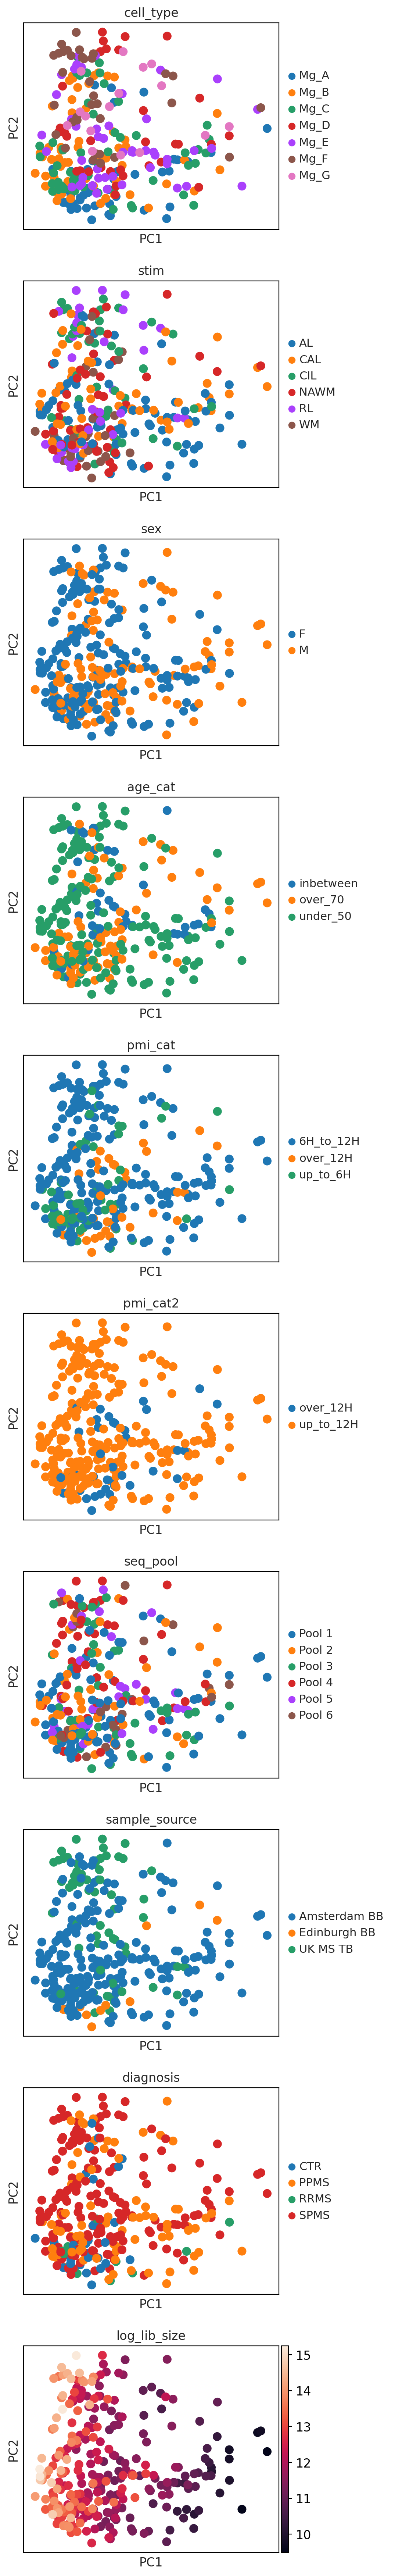

In [49]:
sc.pl.pca(adata_pb, color=["cell_type", "stim", "sex", "age_cat", 
                           "pmi_cat", "pmi_cat2", "seq_pool", "sample_source", "diagnosis", "log_lib_size"], ncols=1, size=300)

In [50]:
adata_pb.X = adata_pb.layers['counts'].copy()
adata_pb

AnnData object with n_obs × n_vars = 292 × 29040
    obs: 'sample', 'sample_lesion', 'diagnosis', 'sample_source', 'cell_type', 'sample_rep', 'replicate_cat', 'stim', 'sex', 'seq_pool', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'batch', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca', 'cell_type_colors', 'stim_colors', 'sex_colors', 'age_cat_colors', 'pmi_cat_colors', 'pmi_cat2_colors', 'seq_pool_colors', 'sample_source_colors', 'diagnosis_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [51]:
adata_pb.write_h5ad('/scratch365/eaboelno/BACKUP_h5ad_IMPORTANT/pb_adata_MG_sep.h5ad')